In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm.auto import tqdm
import statsmodels.api as sm
import warnings
from datetime import datetime, timedelta

# print(plt.style.available) #list of available styles
#plt.style.use('ggplot')
# Configura el estilo de Seaborn para que los gráficos se vean más atractivos
sns.set(style="whitegrid")

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def calc_regresion(r_ind, r):
    res = []
    summary = []
    
    for activo in r.columns:
        X = r_ind
        y = r[activo]
        X_sm = sm.add_constant(X)
        
        modelo = sm.OLS(y, X_sm).fit()
        
        resultado = {
        'activo': activo,
        'alpha': modelo.params[0],
        'beta': modelo.params[1],
        'p_value_alpha': modelo.pvalues[0],
        'p_value_beta': modelo.pvalues[1],
        't_value_alpha': modelo.tvalues[0],
        't_value_beta': modelo.tvalues[1],
        'rsquared': modelo.rsquared,
        'fvalue': modelo.fvalue,
        'conf_int_alpha_low': modelo.conf_int()[0][0],
        'conf_int_alpha_high': modelo.conf_int()[0][1],
        'conf_int_beta_low': modelo.conf_int()[1][0],
        'conf_int_beta_high': modelo.conf_int()[1][1],
        'aic': modelo.aic,
        'bic': modelo.bic
        }
        
        res.append(resultado)
        summary.append(modelo.summary())
        
    df_resul = pd.DataFrame(res)
    df_resul = df_resul.set_index('activo')
    
    df_summ = pd.DataFrame(summary)
    df_summ.index = r.columns
    
    return df_resul, df_summ
        

In [3]:
# Nos bajamoslos precios diarios del SP500 y calculamos los precios semanales, mensuales, trimestrales y anuales

precios_indice = yf.download("SPY")[["Adj Close"]] # Precios ajustados al cierre
precios_indice_semanales=precios_indice.resample('W').last()
precios_indice_mensuales=precios_indice.resample('M').last()
precios_indice_trim=precios_indice.resample('Q').last()
precios_indice_anuales = precios_indice.resample('Y').last()

[*********************100%%**********************]  1 of 1 completed


In [8]:
# Calculamos los retornos diarios, semanales, mensuales, trimestrales y anuales

ret_indice_sp500 = np.log(precios_indice).diff().dropna()
ret_indice_sp500_semanal = np.log(precios_indice_semanales).diff().dropna()
ret_indice_sp500_mensual = np.log(precios_indice_mensuales).diff().dropna()
ret_indice_sp500_trim = np.log(precios_indice_trim).diff().dropna()
ret_indice_sp500_anual = np.log(precios_indice_anuales).diff().dropna()

In [9]:
#Cargar tickers del S&P500 y nos bajamos los precios diarios de los activos
tickers_sp500 = list(pd.read_csv('../data/tickers_sp500.csv').iloc[:,0])

precios = yf.download(tickers_sp500)['Adj Close']

[*********************100%%**********************]  490 of 490 completed


In [25]:
# Nos aseguramos que los datos de los precios contienen los mismos días que los datos del índice SP500
# y calculamos los precios semanales, mensuales, trimestrales y anuales

# Nos aseguramos que los datos de los precios contienen los mismos días que los datos del índice SP500
precios_diarios = precios.copy()
precios_diarios = precios_diarios.loc[precios_indice.index].dropna(axis=1)

# Calculamos los precios semanales, mensuales, trimestrales y anuales
precios_semanales = precios_diarios.resample('W').last()
precios_mensuales = precios_diarios.resample('M').last()
precios_trim = precios_diarios.resample('Q').last()
precios_anuales = precios_diarios.resample('Y').last()

In [26]:
# Calculamos los retornos diarios, semanales, mensuales, trimestrales y anuales de todos los activos del S&P500

retornos_sp500_diarios = np.log(precios_diarios).diff().dropna()
retornos_sp500_semanales = np.log(precios_semanales).diff().dropna()
retornos_sp500_mensuales = np.log(precios_mensuales).diff().dropna()
retornos_sp500_trim = np.log(precios_trim).diff().dropna()
retornos_sp500_anuales = np.log(precios_anuales).diff().dropna()

In [27]:
df_all_res, df_all_summary = calc_regresion(ret_indice_sp500, retornos_sp500_diarios)

In [28]:
df_all_res.head(2)

,alpha,beta,p_value_alpha,p_value_beta,t_value_alpha,t_value_beta,rsquared,fvalue,conf_int_alpha_low,conf_int_alpha_high,conf_int_beta_low,conf_int_beta_high,aic,bic
activo,,,,,,,,,,,,,,
AAPL,0.000331,1.106984,0.225906,0.0,1.211067,47.778687,0.225377,2282.802958,-0.000205,1.061567,0.000868,1.152402,-36123.125256,-36109.189228
ABT,0.000196,0.675220,0.204601,0.0,1.268658,51.567633,0.253133,2659.220731,-0.000107,0.649552,0.000499,0.700887,-45080.375676,-45066.439648


In [29]:

beta_sig = 100 * (df_all_res['p_value_beta']>0.05).sum()/len(df_all_res)
alpha_sig = 100 * (df_all_res['p_value_alpha']>0.05).sum()/len(df_all_res)

print(f"El {beta_sig:.2f}% de los betas no son significativos")

print(f"El {alpha_sig:.2f}% de los alphas no son significativos")

El 0.00% de los betas no son significativos
El 97.01% de los alphas no son significativos


In [30]:
# Veamos los activos con alpha significativo
df_all_res[(df_all_res['p_value_alpha']<0.05)]

,alpha,beta,p_value_alpha,p_value_beta,t_value_alpha,t_value_beta,rsquared,fvalue,conf_int_alpha_low,conf_int_alpha_high,conf_int_beta_low,conf_int_beta_high,aic,bic
activo,,,,,,,,,,,,,,
AIG,-0.000622,1.392826,0.049060,0.000000e+00,-1.968373,52.020828,0.256456,2706.166514,-0.001242,1.340341,-0.000003,1.445311,-33852.998984,-33839.062956
AJG,0.000329,0.634124,0.037217,0.000000e+00,2.083734,47.408199,0.222671,2247.537314,0.000019,0.607904,0.000639,0.660344,-44745.974104,-44732.038076
AZO,0.000390,0.700986,0.039894,0.000000e+00,2.055183,43.610880,0.195109,1901.908864,0.000018,0.669477,0.000762,0.732495,-41862.111585,-41848.175557
BRO,0.000410,0.654817,0.020368,0.000000e+00,2.319962,43.791138,0.196408,1917.663730,0.000064,0.625504,0.000756,0.684129,-42996.268481,-42982.332453
C,-0.000477,1.577056,0.045926,0.000000e+00,-1.996389,77.902492,0.436140,6068.798314,-0.000946,1.537373,-0.000009,1.616740,-38241.422880,-38227.486852
CHD,0.000354,0.455940,0.032114,1.820503e-218,2.143367,32.578191,0.119153,1061.338555,0.000030,0.428506,0.000678,0.483375,-44035.426660,-44021.490632
DHR,0.000368,0.842809,0.011036,0.000000e+00,2.542167,68.825458,0.376458,4736.943622,0.000084,0.818805,0.000651,0.866814,-46131.648570,-46117.712542
WST,0.000340,0.663306,0.047107,0.000000e+00,1.985649,45.737841,0.210501,2091.950085,0.000004,0.634877,0.000676,0.691734,-43476.775103,-43462.839075


Veamos si hay una relación lineal entre las $\beta$ y los retornos de los activo como dice el modelo de mercado:

In [31]:
# Obtener los valores de los retornos promedio del S&P 500 y los valores de beta
retornos_sp500_promedio = retornos_sp500_diarios.mean()
betas = df_all_res['beta']


In [32]:
betas_con_constante = sm.add_constant(betas)

# Crear el modelo OLS
modelo = sm.OLS(retornos_sp500_promedio, betas_con_constante)

# Ajustar el modelo
resultado = modelo.fit()

# Mostrar un resumen del modelo
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.022
Date:                Tue, 02 Apr 2024   Prob (F-statistic):              0.313
Time:                        17:07:53   Log-Likelihood:                 1953.9
No. Observations:                 268   AIC:                            -3904.
Df Residuals:                     266   BIC:                            -3897.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   3.69e-05     10.821      0.0

Hagamos el gráfico de los valores y la regersión lienal

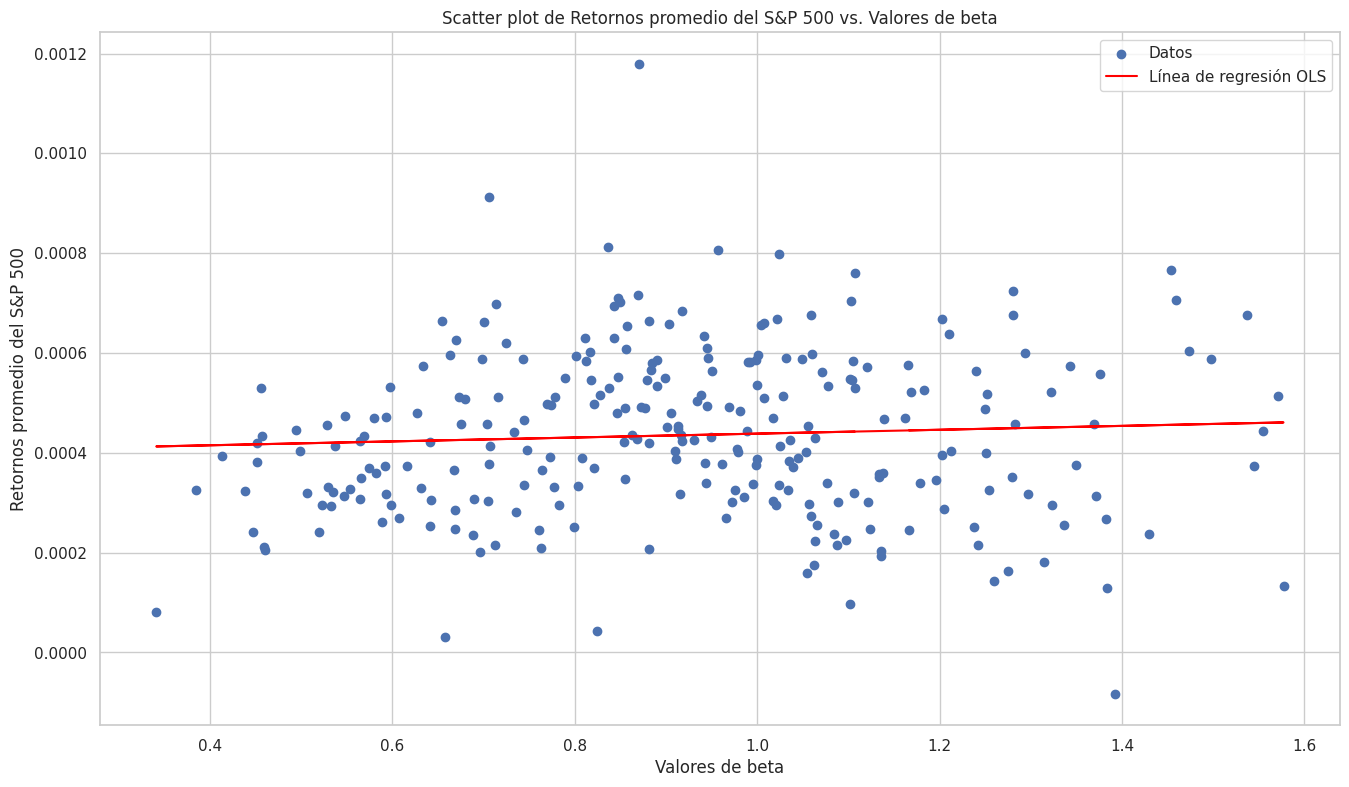

In [33]:
# Obtener los valores ajustados (predicciones del modelo)
valores_ajustados = resultado.predict(betas_con_constante)

# Crear el gráfico de dispersión
plt.scatter(betas, retornos_sp500_promedio, label='Datos')

# Dibujar la línea de regresión
plt.plot(betas, valores_ajustados, color='red', label='Línea de regresión OLS')

# Añadir etiquetas y título
plt.ylabel('Retornos promedio del S&P 500')
plt.xlabel('Valores de beta')
plt.title('Scatter plot de Retornos promedio del S&P 500 vs. Valores de beta')
plt.legend()

# Mostrar el gráfico
plt.show()

Vamos ahora a hacer lo mismo pero con los datos mensuales

In [34]:
df_all_mes_res, df_all_mes_summary = calc_regresion(ret_indice_sp500_mensual, retornos_sp500_mensuales)

In [35]:
# Obtener los valores de los retornos promedio del S&P 500 y los valores de beta
retornos_mes_sp500_promedio = retornos_sp500_mensuales.mean()
betas_mes = df_all_mes_res['beta']

In [36]:
betas_mes_con_constante = sm.add_constant(betas_mes)

# Crear el modelo OLS
modelo = sm.OLS(retornos_mes_sp500_promedio, betas_mes_con_constante)

# Ajustar el modelo
resultado = modelo.fit()

# Mostrar un resumen del modelo
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3028
Date:                Tue, 02 Apr 2024   Prob (F-statistic):              0.583
Time:                        17:10:02   Log-Likelihood:                 1138.6
No. Observations:                 268   AIC:                            -2273.
Df Residuals:                     266   BIC:                            -2266.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.001     15.257      0.0

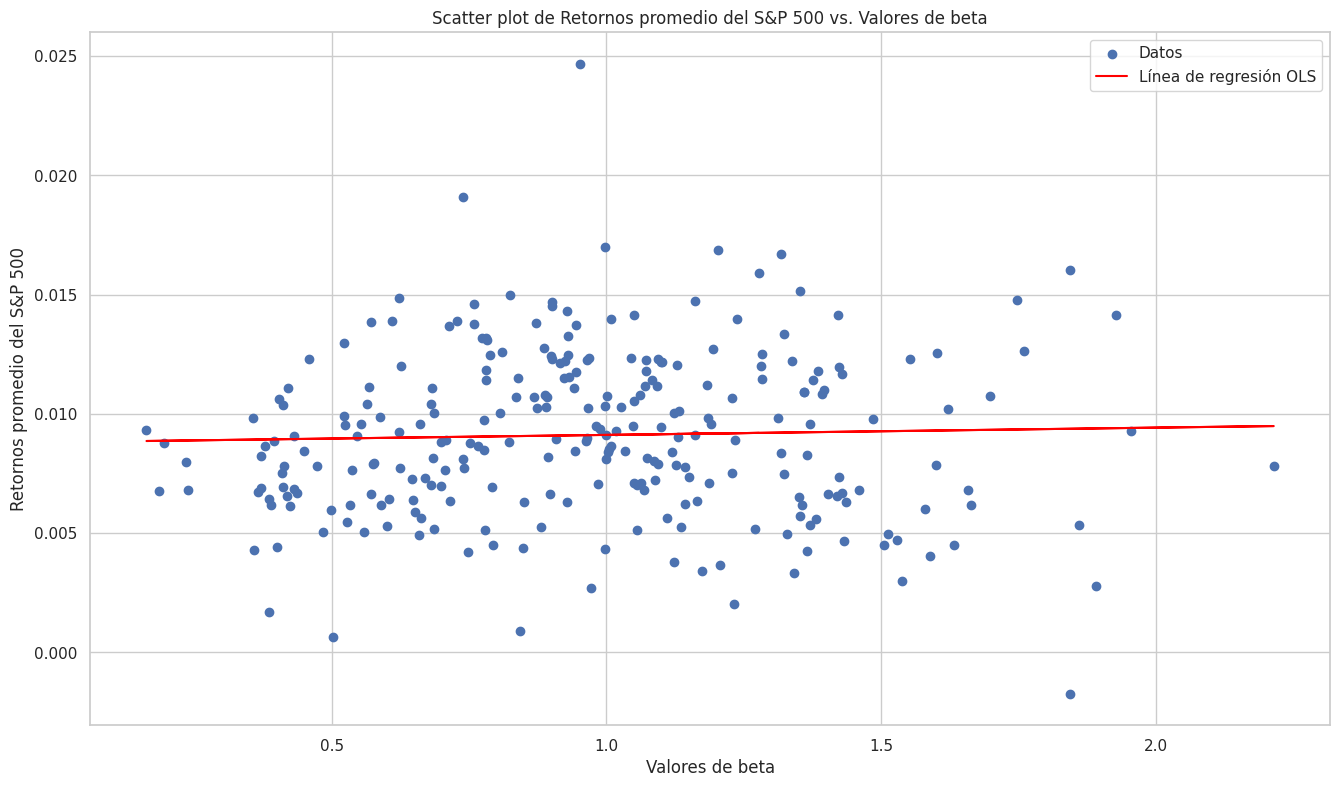

In [37]:
# Obtener los valores ajustados (predicciones del modelo)
valores_mes_ajustados = resultado.predict(betas_mes_con_constante)

# Crear el gráfico de dispersión
plt.scatter(betas_mes, retornos_mes_sp500_promedio, label='Datos')

# Dibujar la línea de regresión
plt.plot(betas_mes, valores_mes_ajustados, color='red', label='Línea de regresión OLS')

# Añadir etiquetas y título
plt.ylabel('Retornos promedio del S&P 500')
plt.xlabel('Valores de beta')
plt.title('Scatter plot de Retornos promedio del S&P 500 vs. Valores de beta')
plt.legend()

# Mostrar el gráfico
plt.show()

Comparemos las $\beta$ calculadas con datos diarios y con mensuales

In [38]:
comparar_betas = pd.DataFrame({'diario': df_all_res['beta'], 'mensual': df_all_mes_res['beta']})

comparar_betas['% diff'] = np.round(100 * (comparar_betas['diario'] - comparar_betas['mensual'])/comparar_betas['diario'], 2)

comparar_betas


,diario,mensual,% diff
activo,,,
AAPL,1.106984,1.278039,-15.45
ABT,0.675220,0.552896,18.12
ADBE,1.280488,1.420929,-10.97
ADI,1.293827,1.601897,-23.81
ADM,0.782878,0.589738,24.67
...,...,...,...
XEL,0.533365,0.424364,20.44
XOM,0.807749,0.683760,15.35
XRAY,0.695805,0.749095,-7.66


Vamos a ver cómo podemos uasr las $ \beta $ para gestionar carteras

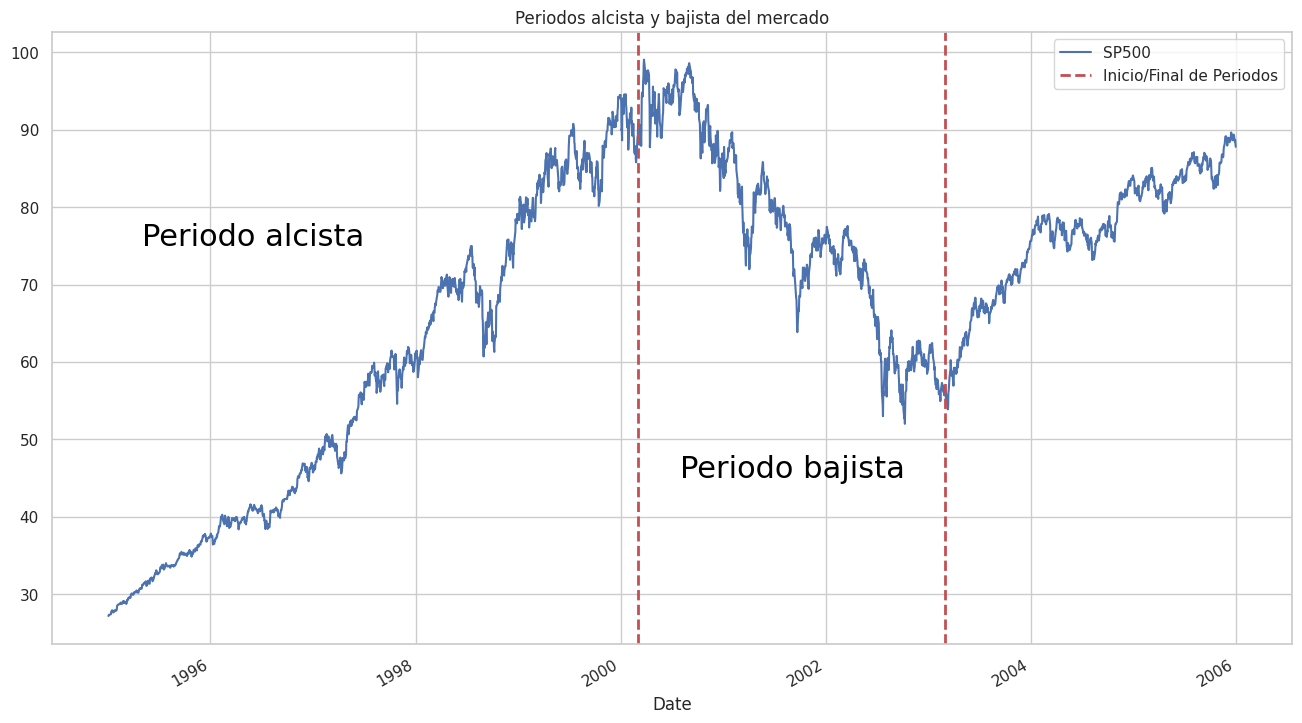

In [39]:
precios_indice.loc['1995':'2005'].plot(label='SP500')

# Añadir líneas verticales rojas punteadas en las fechas especificadas
plt.axvline('2000-03-01', color='r', linestyle='--', linewidth=2, label='Inicio/Final de Periodos')
plt.axvline('2003-03-01', color='r', linestyle='--', linewidth=2)

# Añadir texto para el periodo alcista
plt.text('1995-05', 75, 'Periodo alcista', fontsize=22, color='black')

# Añadir texto para el periodo alcista
plt.text('2000-8', 45, 'Periodo bajista', fontsize=22, color='black')

# Añadir título al gráfico
plt.title('Periodos alcista y bajista del mercado')

# Opcional: Añadir leyenda para explicar las líneas rojas
# Añadir manualmente la leyenda con las etiquetas deseadas
plt.legend(['SP500', 'Inicio/Final de Periodos'])

# Mostrar el gráfico
plt.show()


In [40]:
precios_antes = precios_diarios.loc['1995':'2000']

precios_bajada = precios_diarios.loc['2001':'2002']

precios_despues = precios_diarios.loc['2003':'2005']

precios_ant_baj = precios_diarios.loc['1995':'2002']

In [41]:
retornos_ant = np.log(precios_antes).diff().dropna()
retornos_baj = np.log(precios_bajada).diff().dropna()
retornos_des = np.log(precios_despues).diff().dropna()
retornos_ant_baj = np.log(precios_ant_baj).diff().dropna()


In [42]:
precios_indice_antes = precios_indice.loc['1995':'2000']

precios_indice_bajada = precios_indice.loc['2001':'2002']

precios_indice_despues = precios_indice.loc['2003':'2005']

precios_indice_ant_baj = precios_indice.loc['1995':'2002']

In [43]:
retornos_indice_ant = np.log(precios_indice_antes).diff().dropna()
retornos_indice_baj = np.log(precios_indice_bajada).diff().dropna()
retornos_indice_des = np.log(precios_indice_despues).diff().dropna()
retornos_indice_ant_baj = np.log(precios_indice_ant_baj).diff().dropna()


In [44]:
df_ant_resul, df_ant_summ = calc_regresion(retornos_indice_ant, retornos_ant)

In [45]:
# Obtener los valores de los retornos promedio del S&P 500 y los valores de beta
retornos_sp500_ant_promedio = retornos_ant.mean()
betas_ant = df_ant_resul['beta']


In [46]:
betas_ant_con_constante = sm.add_constant(betas_ant)

# Crear el modelo OLS
modelo = sm.OLS(retornos_sp500_ant_promedio, betas_ant_con_constante)

# Ajustar el modelo
resultado = modelo.fit()

# Mostrar un resumen del modelo
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     63.38
Date:                Tue, 02 Apr 2024   Prob (F-statistic):           4.96e-14
Time:                        17:13:27   Log-Likelihood:                 1672.6
No. Observations:                 268   AIC:                            -3341.
Df Residuals:                     266   BIC:                            -3334.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   6.57e-05      4.012      0.0

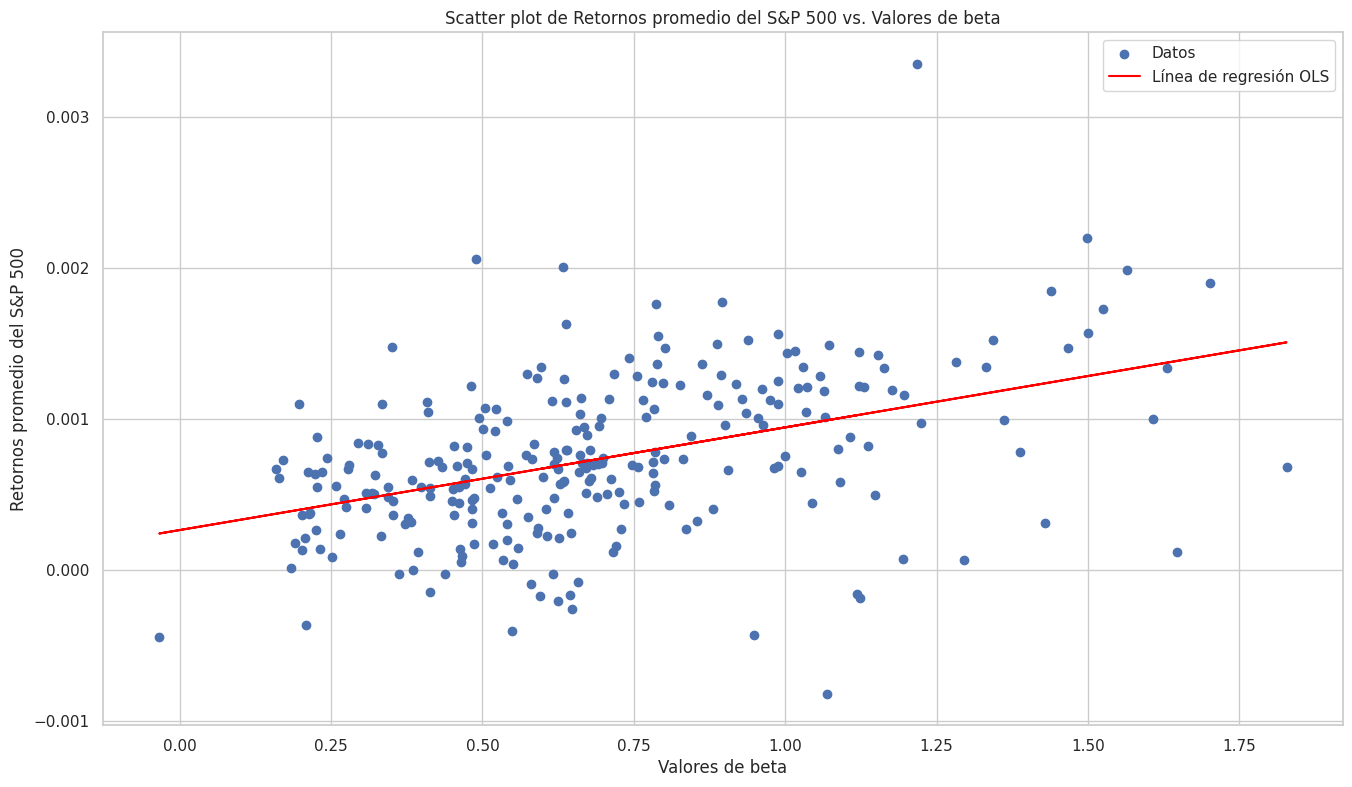

In [51]:
# Obtener los valores ajustados (predicciones del modelo)
valores_ant_ajustados = resultado.predict(betas_ant_con_constante)

# Crear el gráfico de dispersión
plt.scatter(betas_ant, retornos_sp500_ant_promedio, label='Datos')

# Dibujar la línea de regresión
plt.plot(betas_ant, valores_ant_ajustados, color='red', label='Línea de regresión OLS')

# Añadir etiquetas y título
plt.ylabel('Retornos promedio del S&P 500')
plt.xlabel('Valores de beta')
plt.title('Scatter plot de Retornos promedio del S&P 500 vs. Valores de beta')
plt.legend()

# Mostrar el gráfico
plt.show()

Ahora para el periodo de caída del mercado

In [52]:
df_baj_resul, df_baj_summ = calc_regresion(retornos_indice_baj, retornos_baj)

In [53]:
# Obtener los valores de los retornos promedio del S&P 500 y los valores de beta
retornos_sp500_baj_promedio = retornos_baj.mean()
betas_baj = df_baj_resul['beta']

In [54]:
betas_baj_con_constante = sm.add_constant(betas_baj)

# Crear el modelo OLS
modelo = sm.OLS(retornos_sp500_baj_promedio, betas_baj_con_constante)

# Ajustar el modelo
resultado = modelo.fit()

# Mostrar un resumen del modelo
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     64.72
Date:                Tue, 02 Apr 2024   Prob (F-statistic):           2.86e-14
Time:                        17:27:48   Log-Likelihood:                 1471.5
No. Observations:                 268   AIC:                            -2939.
Df Residuals:                     266   BIC:                            -2932.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      5.431      0.0

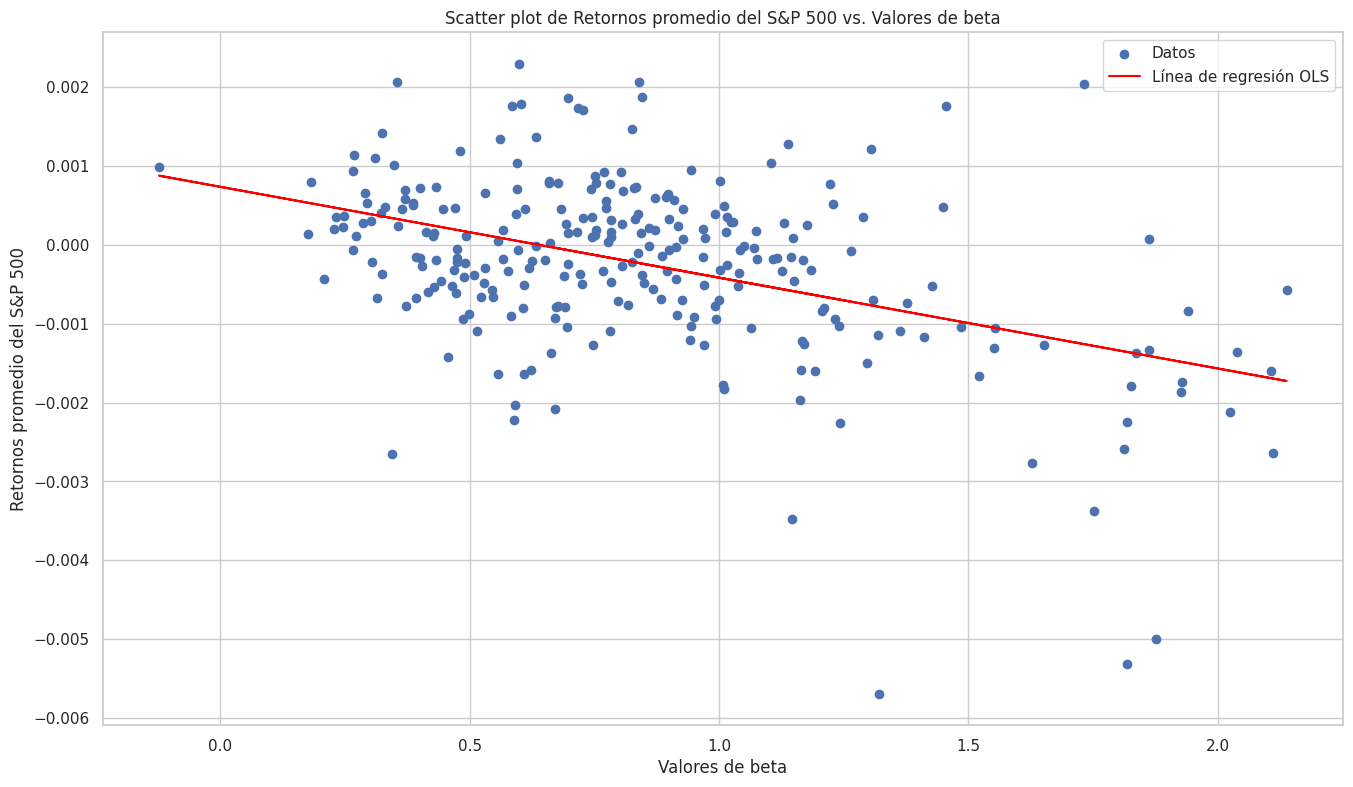

In [55]:
# Obtener los valores ajustados (predicciones del modelo)
valores_baj_ajustados = resultado.predict(betas_baj_con_constante)

# Crear el gráfico de dispersión
plt.scatter(betas_baj, retornos_sp500_baj_promedio, label='Datos')

# Dibujar la línea de regresión
plt.plot(betas_baj, valores_baj_ajustados, color='red', label='Línea de regresión OLS')

# Añadir etiquetas y título
plt.ylabel('Retornos promedio del S&P 500')
plt.xlabel('Valores de beta')
plt.title('Scatter plot de Retornos promedio del S&P 500 vs. Valores de beta')
plt.legend()

# Mostrar el gráfico
plt.show()

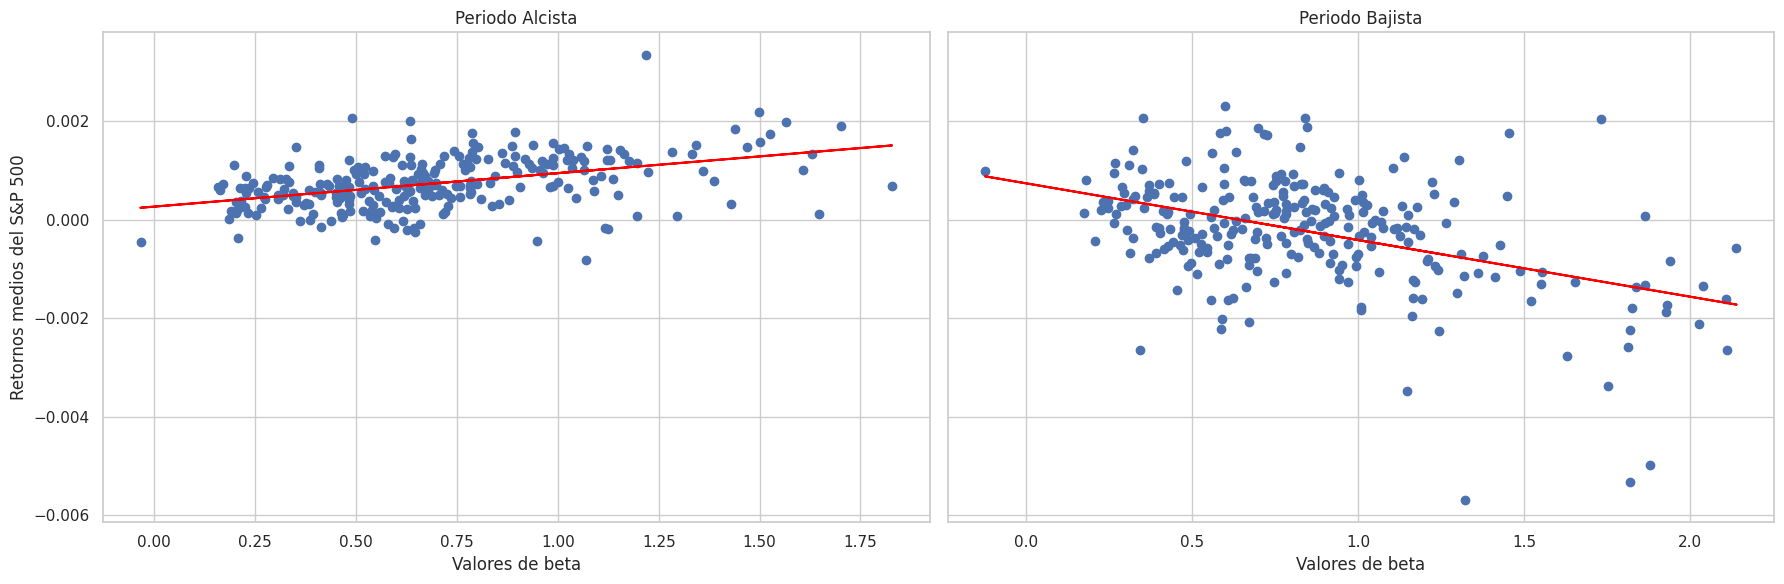

In [63]:


# Creación de la figura y los ejes
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Primer gráfico
axs[0].scatter(betas_ant, retornos_sp500_ant_promedio, label='Datos')
axs[0].plot(betas_ant, valores_ant_ajustados, color='red', label='Línea de regresión OLS')
axs[0].set_ylabel('Retornos medios del S&P 500')
axs[0].set_xlabel('Valores de beta')
axs[0].set_title('Periodo Alcista')



# Segundo gráfico
axs[1].scatter(betas_baj, retornos_sp500_baj_promedio, label='Datos')
axs[1].plot(betas_baj, valores_baj_ajustados, color='red', label='Línea de regresión OLS')
#axs[1].set_ylabel('Retornos medios del S&P 500')
axs[1].set_xlabel('Valores de beta')
axs[1].set_title('Periodo Bajista')



# Ajusta automáticamente los parámetros de la subtrama para todo el layout
plt.tight_layout()

# Mostrar la figura completa con ambos gráficos
plt.show()


In [51]:
df_ant_beta_ordenado = df_ant_resul.sort_values(by='beta', ascending=False)
tickers_beta_alta = list(df_ant_beta_ordenado.head(10).index)
tickers_beta_baja = list(df_ant_beta_ordenado.iloc[-11:-1,:].index)

In [52]:
pesos_alta = np.ones(len(tickers_beta_alta))/len(tickers_beta_alta)
pesos_baja = np.ones(len(tickers_beta_baja))/len(tickers_beta_baja)

In [56]:
df_ant_beta_ordenado.loc[tickers_beta_alta, 'beta'].shape,  retornos_cartera_alta.mean().shape 

((10,), ())

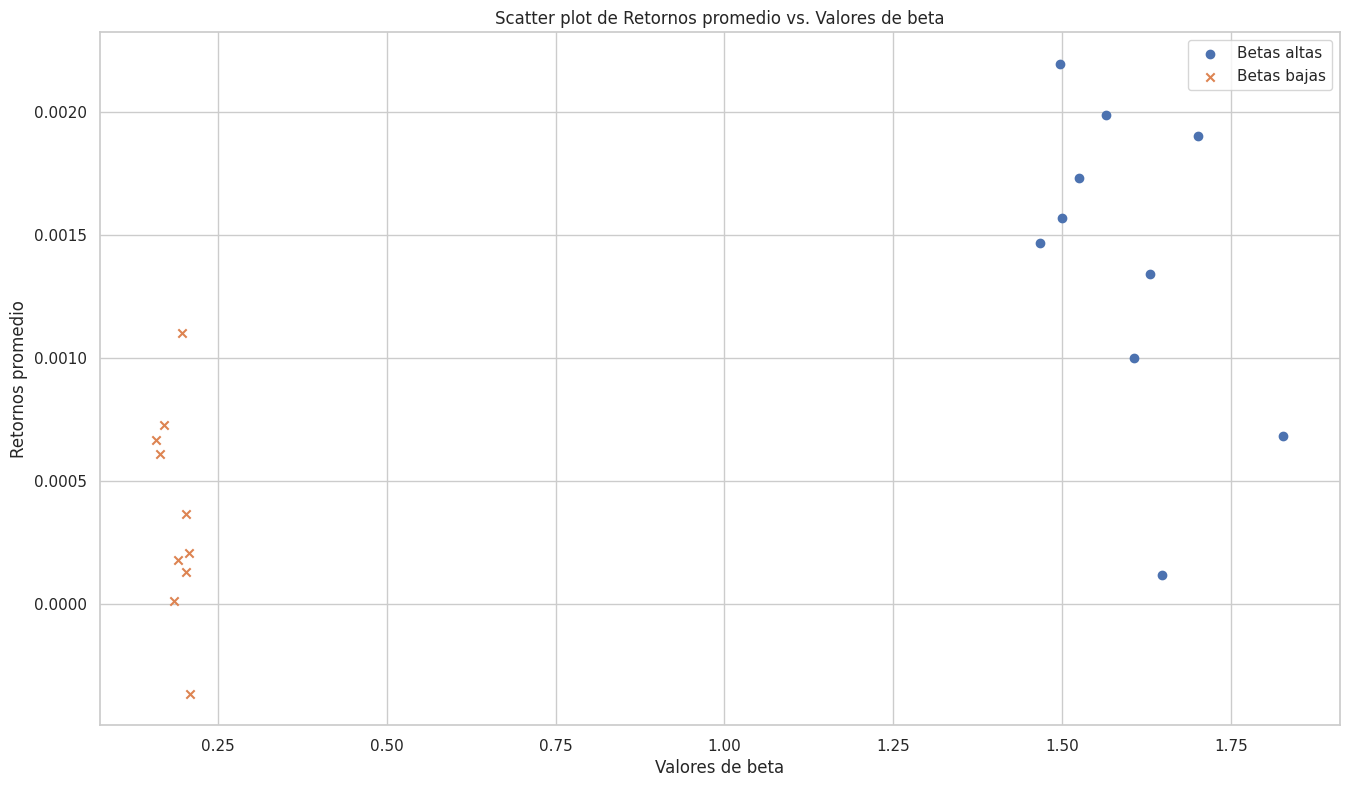

In [68]:
# Crear el gráfico de dispersión
plt.scatter(df_ant_beta_ordenado.loc[tickers_beta_alta, 'beta'], retornos_ant[tickers_beta_alta].mean(), label='Datos')

plt.scatter(df_ant_beta_ordenado.loc[tickers_beta_baja, 'beta'], retornos_ant[tickers_beta_baja].mean(), label='Datos', marker='x')


# Añadir etiquetas y título
plt.ylabel('Retornos promedio')
plt.xlabel('Valores de beta')
plt.title('Scatter plot de Retornos promedio vs. Valores de beta')
plt.legend(['Betas altas', 'Betas bajas'])


# Mostrar el gráfico
plt.show()

In [21]:
retornos_cartera_alta =(retornos_baj.loc[:, tickers_beta_alta]@pesos_alta)

retornos_cartera_baja = (retornos_baj.loc[:, tickers_beta_baja]@pesos_baja)

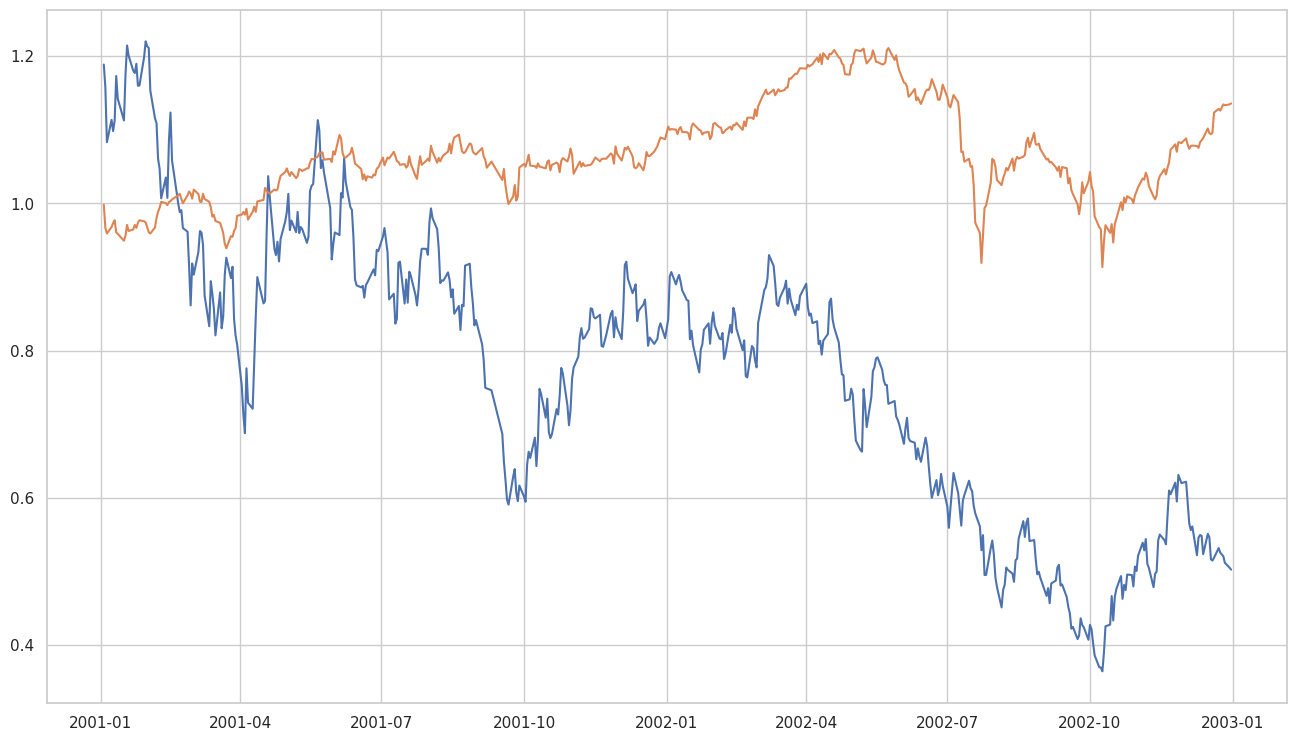

In [22]:
plt.plot(np.exp(retornos_cartera_alta.cumsum()), label='Cartera con betas altas')
plt.plot(np.exp(retornos_cartera_baja.cumsum()), label='Cartera con betas bajas')

<Axes: xlabel='Date'>

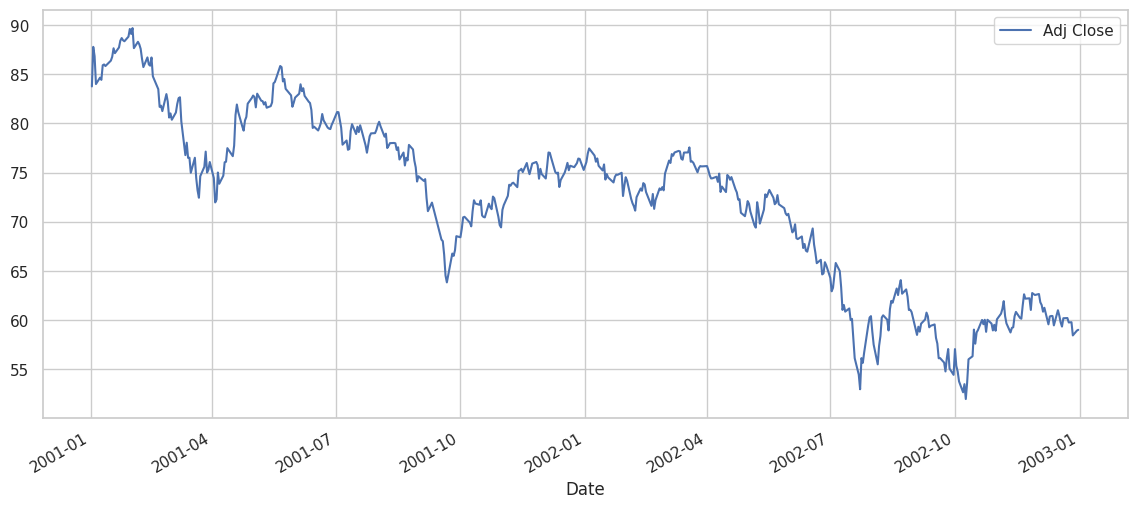

In [160]:
precios_indice.loc['2001':'2002'].plot(figsize=(14,6))

<Axes: xlabel='Date'>

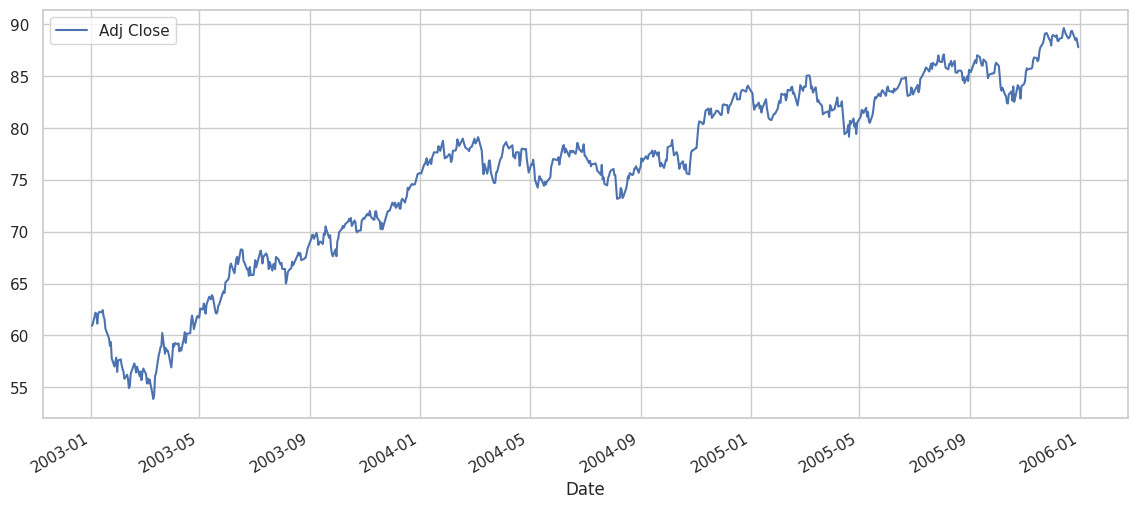

In [161]:
precios_indice.loc['2003':'2005'].plot(figsize=(14,6))